# Submission 8 is the best right now with public LB of 95.451
# Logit + xgboost + 6 hand-engineered features

In [1]:
import os
import pickle
import numpy as np
import pandas as pd
from scipy.sparse import hstack
# !pip install eli5
import eli5
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot as plt
import seaborn as sns
from IPython.display import display_html

/home/jash/miniconda3/envs/ml/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
def prepare_sparse_features(path_to_train, path_to_test, path_to_site_dict,
                           vectorizer_params):
    times = ['time%s' % i for i in range(1, 11)]
    train_df = pd.read_csv(path_to_train,
                       index_col='session_id', parse_dates=times)
    test_df = pd.read_csv(path_to_test,
                      index_col='session_id', parse_dates=times)

    # Sort the data by time
    train_df = train_df.sort_values(by=times)
    # read site -> id mapping provided by competition organizers 
    with open(path_to_site_dict, 'rb') as f:
        site2id = pickle.load(f)
    # create an inverse id _> site mapping
    id2site = {v:k for (k, v) in site2id.items()}
    # we treat site with id 0 as "unknown"
    id2site[0] = 'unknown'
    
    # Transform data into format which can be fed into TfidfVectorizer
    # This time we prefer to represent sessions with site names, not site ids. 
    # It's less efficient but thus it'll be more convenient to interpret model weights.
    sites = ['site%s' % i for i in range(1, 11)]
    train_sessions = train_df[sites].fillna(0).astype('int').apply(lambda row: 
                                                     ' '.join([id2site[i] for i in row]), axis=1).tolist()
    test_sessions = test_df[sites].fillna(0).astype('int').apply(lambda row: 
                                                     ' '.join([id2site[i] for i in row]), axis=1).tolist()
    # we'll tell TfidfVectorizer that we'd like to split data by whitespaces only 
    # so that it doesn't split by dots (we wouldn't like to have 'mail.google.com' 
    # to be split into 'mail', 'google' and 'com')
    vectorizer = TfidfVectorizer(**vectorizer_params)
    X_train = vectorizer.fit_transform(train_sessions)
    X_test = vectorizer.transform(test_sessions)
    y_train = train_df['target'].astype('int').values
    
    # we'll need site visit times for further feature engineering
    train_times, test_times = train_df[times], test_df[times]
    train_sites, test_sites = train_df[sites], test_df[sites]
    
    return X_train, X_test, y_train, vectorizer, train_times, test_times,train_sites,test_sites

In [3]:
X_train_sites, X_test_sites, y_train, vectorizer, train_times, test_times,train_sites,test_sites = prepare_sparse_features(
    path_to_train='train_sessions.csv',
    path_to_test='test_sessions.csv',
    path_to_site_dict='site_dic.pkl',
    vectorizer_params={'ngram_range': (1, 3), 
                       'max_features': 50000,
                       'tokenizer': lambda s: s.split()}
)

In [4]:
time_split = TimeSeriesSplit(n_splits=10)

In [5]:
def write_to_submission_file(predicted_labels, out_file,
                             target='target', index_label="session_id"):
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(1, predicted_labels.shape[0] + 1),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)

In [6]:
def train_and_predict(model, X_train, y_train, X_test, site_feature_names=vectorizer.get_feature_names(), 
                      new_feature_names=None, cv=time_split, scoring='roc_auc',
                      top_n_features_to_show=30, submission_file_name='submission.csv'):
    
    
    cv_scores = cross_val_score(model, X_train, y_train, cv=cv, 
                            scoring=scoring, n_jobs=4)
    print('CV scores', cv_scores)
    print('CV mean: {}, CV std: {}'.format(cv_scores.mean(), cv_scores.std()))
    model.fit(X_train, y_train)
    
    if new_feature_names:
        all_feature_names = site_feature_names + new_feature_names 
    else: 
        all_feature_names = site_feature_names
    
    display_html(eli5.show_weights(estimator=model, 
                  feature_names=all_feature_names, top=top_n_features_to_show))
    
    if new_feature_names:
        print('New feature weights:')
    
        print(pd.DataFrame({'feature': new_feature_names, 
                       'coef': model.coef_.flatten()[-len(new_feature_names):]}))
    
    test_pred = model.predict_proba(X_test)[:, 1]
    write_to_submission_file(test_pred, submission_file_name) 
    
    return cv_scores

/home/jash/miniconda3/envs/ml/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/jash/miniconda3/envs/ml/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


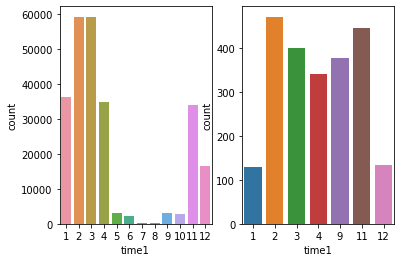

In [10]:
plt.subplot(121)
sns.countplot(train_times['time1'].apply(lambda x : x.month).loc[y_train ==0]);
plt.subplot(122)
sns.countplot(train_times['time1'].apply(lambda x : x.month).loc[y_train ==1]);

In [34]:
with open('site_dic.pkl', 'rb') as f:
        site_dict = pickle.load(f)
facebook_ids = []
youtube_ids = []
google_ids = []
for key in list(site_dict.keys()):
    if 'facebook' in key:
        facebook_ids.append(site_dict[key])
    if 'youtube' in key:
        youtube_ids.append(site_dict[key])
    if 'google' in key:
        google_ids.append(site_dict[key])

In [35]:
def is_site(x, l):
    if x in l:
        return 1 
    return 0

In [50]:
def add_time_features(sites,times,X_sparse,std_scalar,train = True):
        time_diff = (times.max(axis = 1) - times.min(axis = 1)).astype('timedelta64[ms]').astype(int).values.reshape(-1,1)
        hour = times['time1'].apply(lambda x : x.hour).fillna(-1)
        hour_morning = hour.apply(lambda x : x in [8,9,10,11]).astype(int).values.reshape(-1,1)
        hour_night = hour.apply(lambda x : x in [16,17]).astype(int).values.reshape(-1,1)
        morning = ((hour >= 7) & (hour <= 11)).astype('int').values.reshape(-1, 1)
        day = ((hour >= 12) & (hour <= 18)).astype('int').values.reshape(-1, 1)
        evening = ((hour >= 19) & (hour <= 23)).astype('int').values.reshape(-1, 1)
        month = times['time1'].apply(lambda x : x.month).fillna(-1)
        summer = (((month >= 6) & (month <= 8)).astype('int')).values.reshape(-1,1)
        season = (((month >= 2) & (month <= 3)).astype('int')).values.reshape(-1,1)
        yb_start = sites['site1'].apply(lambda x: is_site(x, youtube_ids)).values.reshape(-1,1)
        fb_start = sites['site1'].apply(lambda x: is_site(x, facebook_ids)).values.reshape(-1,1)
        yb_end = sites['site10'].apply(lambda x: is_site(x, youtube_ids)).values.reshape(-1,1)
        fb_end = sites['site10'].apply(lambda x: is_site(x, facebook_ids)).values.reshape(-1,1)
        google_start = sites['site1'].apply(lambda x: is_site(x, google_ids)).values.reshape(-1,1)
        google_end = sites['site10'].apply(lambda x : is_site(x,google_ids)).values.reshape(-1,1)
        work_hours = times['time1'].apply(lambda ts: 1 if (ts.date().weekday() in (0,1,2,3)) &
                                             ((ts.hour>=8)&(ts.hour<=17)&(ts.hour!=12)) else 0).astype('int').values.reshape(-1,1)
        #night = ((hour >= 0) & (hour <=6)).astype('int').values.reshape(-1, 1)
        #time_columns = np.hstack([morning,day,evening,night])
        #is_weekend = times['time1'].apply(lambda t: t.weekday()).map({0:0,1:0,2:0,3:0,4:0,5:1,6:1}).values.reshape(-1, 1)
        #day_of_week = times['time1'].apply(lambda t: t.weekday()).values.reshape(-1, 1)
        special_day = times['time1'].apply(lambda t : (t.weekday()==5) or (t.weekday()==6) or (t.weekday()==2)).values.reshape(-1,1)
        month = times['time1'].apply(lambda t: t.month).values.reshape(-1, 1) 
        # linear trend: time in a form YYYYMM, we'll divide by 1e5 to scale this feature 
        year_month = times['time1'].apply(lambda t: 100 * t.year + t.month).values.reshape(-1, 1) / 1e5
        #print(time_columns.shape)
        new_feature_names = ['morning','day','evening','summer','season','yb_start','fb_start','google_start','day_of_week','year_month','time_diff']
        if train:
                time_diff = std_scalar.fit_transform(time_diff)
        else:
                time_diff = std_scalar.transform(time_diff)
        
        X = hstack([X_sparse,morning,day,evening,summer,season,yb_start,fb_start,google_start,special_day,year_month,time_diff])
        return X,new_feature_names


/home/jash/miniconda3/envs/ml/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/jash/miniconda3/envs/ml/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


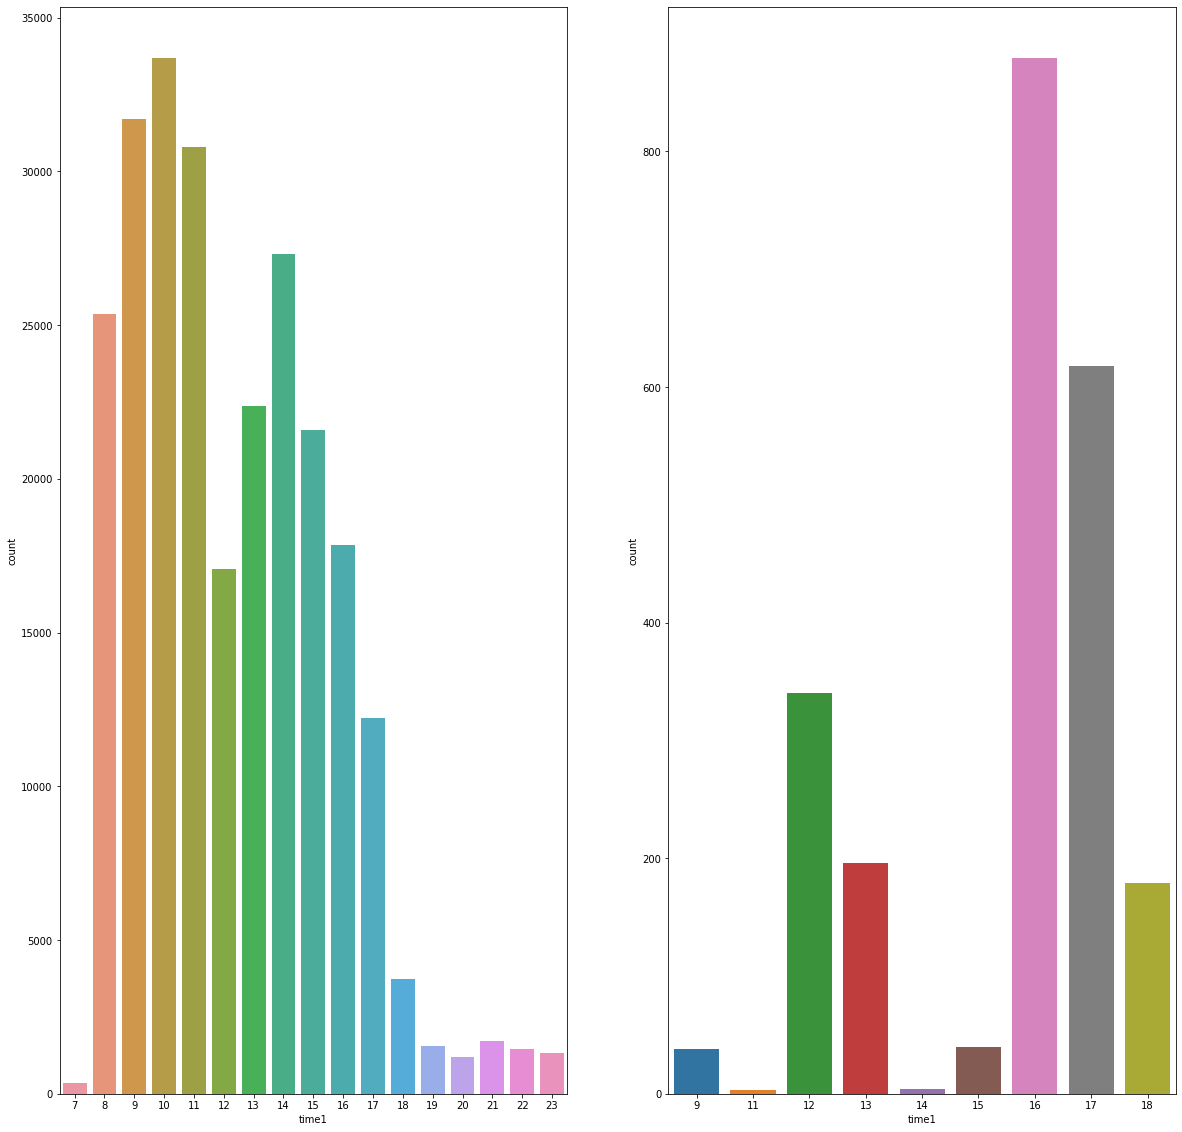

In [136]:
plt.figure(figsize = (20,20))
plt.subplot(121)
sns.countplot(train_times['time1'].apply(lambda x : x.hour).loc[y_train==0])
plt.subplot(122)
sns.countplot(train_times['time1'].apply(lambda x : x.hour).loc[y_train == 1])

/home/jash/miniconda3/envs/ml/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/jash/miniconda3/envs/ml/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


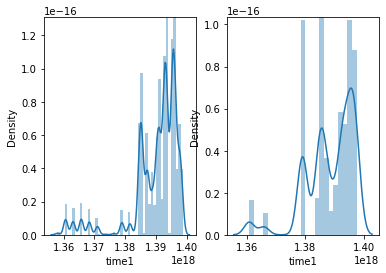

In [155]:
plt.subplot(121)
sns.distplot(train_times['time1'].loc[y_train == 0]);
plt.subplot(122)
sns.distplot(train_times['time1'].loc[y_train == 1]);

In [153]:
train_times['time1'].value_counts()

2014-02-26 11:16:32    6
2014-03-27 08:11:18    6
2013-10-12 09:58:54    5
2014-02-04 08:08:44    5
2014-03-26 09:34:57    5
                      ..
2014-03-19 08:01:01    1
2014-04-16 11:36:06    1
2013-11-28 13:38:05    1
2014-03-23 15:50:58    1
2014-01-20 14:08:33    1
Name: time1, Length: 236707, dtype: int64

/home/jash/miniconda3/envs/ml/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


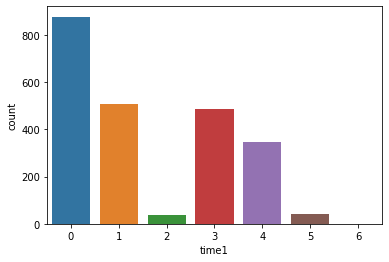

In [137]:
sns.countplot(train_times.loc[y_train == 1,'time1'].apply(lambda t: t.weekday()));

In [138]:
train_times['time1'].apply(lambda t: t.weekday()).map({0:0,1:0,2:0,3:0,4:0,5:1,6:1})

session_id
21669     1
54843     1
77292     1
114021    1
146670    1
         ..
12224     0
164438    0
12221     0
156968    0
204762    0
Name: time1, Length: 253561, dtype: int64

In [51]:
scalar = StandardScaler()

In [52]:
X_train_sites.shape

(253561, 50000)

In [53]:
X_train,new_feature_names= add_time_features(train_sites,train_times,X_train_sites,scalar)

/home/jash/miniconda3/envs/ml/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


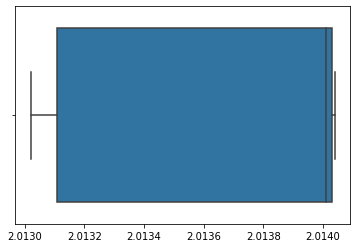

In [142]:
sns.boxplot(X_train.data[-253561:][y_train == 1])

In [55]:
X_train.shape

(253561, 50011)

In [54]:
X_test,new_feature_names= add_time_features(test_sites,test_times,X_test_sites,scalar,train = False)

In [56]:
X_test.shape

(82797, 50011)

In [57]:
logit = LogisticRegression(random_state = 42)

In [58]:
c_values = np.logspace(-2,2,20)
logit_grid_searcher = GridSearchCV(estimator=logit, param_grid={'C': c_values},
                                  scoring='roc_auc', n_jobs=-1, cv=time_split, verbose=1)

In [59]:
logit_grid_searcher.fit(X_train,y_train)

Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   22.2s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  3.9min finished
/home/jash/miniconda3/envs/ml/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=10),
             error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=42, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': array([1.00000000e-02, 1.62377674e-02, 2.63665090e-02, 4.28133240e-02,
       6.95192796e-02, 1.12883789e-01, 1.83298071e-01, 2.97635144e-01,
       4.83293024e-01, 7.84759970e-01, 1.27427499e+00, 2.06913808e+00,
       3.35981829e+00, 5.45559478e+00, 8.85866790e+0

In [60]:
logit_grid_searcher.best_score_,logit_grid_searcher.best_params_

(0.922130902267359, {'C': 5.455594781168514})

In [61]:
df = pd.DataFrame({'feature': new_feature_names, 
                       'coef': logit_grid_searcher.best_estimator_.coef_.flatten()[-len(new_feature_names):]})

In [62]:
df

,feature,coef
0,morning,-1.165644
1,day,2.805448
2,evening,-2.835653
3,summer,-2.539587
4,season,-0.415221
5,yb_start,0.172871
6,fb_start,0.098116
7,google_start,-0.053651
8,day_of_week,-2.606326
9,year_month,-2.983386


In [49]:
cv_scores10 = train_and_predict(logit_grid_searcher.best_estimator_, X_train, y_train, X_test, site_feature_names=vectorizer.get_feature_names(), 
                      new_feature_names=new_feature_names, cv=time_split, scoring='roc_auc',
                      top_n_features_to_show=30, submission_file_name='submission13.csv')

CV scores [0.92021726 0.86508833 0.79926684 0.98106899 0.92542779 0.96976409
 0.93810404 0.9513779  0.90975019 0.96138049]
CV mean: 0.9221445925017615, CV std: 0.05187573794609578


/home/jash/miniconda3/envs/ml/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Weight?,Feature
+10.051,cid-ed6c3e6a5c6608a4.users.storage.live.com
+9.984,www.express.co.uk
+7.082,fr.glee.wikia.com
+6.690,www.banque-chalus.fr
+6.385,tru.am
+6.380,browser-update.org
+6.269,www.monalbumphoto.fr
+6.218,www.video.tt
+6.038,www.jeux.com
+5.967,youwatch.org


New feature weights:
        feature      coef
0       morning -1.196739
1           day  2.477048
2       evening -2.394969
3        summer -2.077617
4        season -0.360585
5  google_start -0.112974
6    google_end -0.033586
7   day_of_week -2.834012
8    year_month -2.668600
9     time_diff -0.232765


In [26]:
cv_scores9 = train_and_predict(logit_grid_searcher.best_estimator_, X_train, y_train, X_test, site_feature_names=vectorizer.get_feature_names(), 
                      new_feature_names=new_feature_names, cv=time_split, scoring='roc_auc',
                      top_n_features_to_show=30, submission_file_name='submission12.csv')

CV scores [0.91881591 0.85264793 0.81161989 0.98532413 0.92083729 0.96528713
 0.94913922 0.94763592 0.92011439 0.95654952]
CV mean: 0.922797133506425, CV std: 0.05047107884146922


/home/jash/miniconda3/envs/ml/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Weight?,Feature
+14.714,cid-ed6c3e6a5c6608a4.users.storage.live.com
+14.629,www.express.co.uk
+10.874,fr.glee.wikia.com
+10.028,www.banque-chalus.fr
+9.512,tru.am
+9.162,www.monalbumphoto.fr
+8.912,browser-update.org
+8.751,www.video.tt
+8.701,glee.hypnoweb.net
+7.994,www.jeux.com


New feature weights:
       feature      coef
0      morning -0.863920
1          day  3.475401
2      evening -4.073062
3       summer -3.332838
4       season -0.438764
5  day_of_week -2.968792
6   year_month -3.625992
7    time_diff -0.192053


In [68]:
cv_scores8 = train_and_predict(logit_grid_searcher.best_estimator_, X_train, y_train, X_test, site_feature_names=vectorizer.get_feature_names(), 
                      new_feature_names=new_feature_names, cv=time_split, scoring='roc_auc',
                      top_n_features_to_show=30, submission_file_name='submission11.csv')

CV scores [0.91900677 0.85260656 0.80263712 0.98766879 0.92052182 0.96390944
 0.95216827 0.94787249 0.91505154 0.9582493 ]
CV mean: 0.9219692108998416, CV std: 0.05299497699258562


/home/jash/miniconda3/envs/ml/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Weight?,Feature
+14.765,www.express.co.uk
+14.336,cid-ed6c3e6a5c6608a4.users.storage.live.com
+11.039,fr.glee.wikia.com
+9.939,www.banque-chalus.fr
+9.652,tru.am
+8.925,www.monalbumphoto.fr
+8.864,browser-update.org
+8.335,glee.hypnoweb.net
+8.319,www.rhonealpesjob.com
+8.183,www.video.tt


New feature weights:
       feature      coef
0      morning -0.960477
1          day  2.996240
2      evening -3.302783
3       summer -3.046701
4     yb_start  0.261973
5       fb_end  0.074666
6  day_of_week -2.620915
7   year_month -3.447202


In [39]:
cv_scores7 = train_and_predict(logit_grid_searcher.best_estimator_, X_train, y_train, X_test, site_feature_names=vectorizer.get_feature_names(), 
                      new_feature_names=new_feature_names, cv=time_split, scoring='roc_auc',
                      top_n_features_to_show=30, submission_file_name='submission10.csv')

CV scores [0.91980966 0.85305342 0.79981949 0.98564761 0.91994846 0.96376424
 0.95068672 0.94835547 0.91669131 0.9554608 ]
CV mean: 0.921323718276064, CV std: 0.05305351673212326


/home/jash/miniconda3/envs/ml/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Weight?,Feature
+15.064,www.express.co.uk
+14.743,cid-ed6c3e6a5c6608a4.users.storage.live.com
+9.893,fr.glee.wikia.com
+9.717,tru.am
+9.254,www.banque-chalus.fr
+9.032,www.monalbumphoto.fr
+8.966,browser-update.org
+8.573,www.rhonealpesjob.com
+7.980,r2---sn-aigllm7e.googlevideo.com
+7.926,glee.hypnoweb.net


New feature weights:
       feature      coef
0      morning -1.137739
1          day  2.795363
2      evening -2.814956
3       summer -2.802771
4  day_of_week -2.504839
5   year_month -3.308090


In [63]:
## Hyperparameter optimization using RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import xgboost

In [64]:
classifier=xgboost.XGBClassifier()

In [65]:
params={
 "learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
 "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
 "min_child_weight" : [ 1, 3, 5, 7 ],
 "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
 "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ]
    
}

In [66]:
xgb_random=RandomizedSearchCV(classifier,param_distributions=params,n_iter=10,scoring='roc_auc',n_jobs=-1,cv=time_split,verbose=True)

In [67]:
xgb_random.fit(X_train,y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 14.5min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 29.2min finished


RandomizedSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=10),
                   error_score=nan,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=1, nthread=None,
                                           objective='binary:logis...
                                           verbosity=1),
                   iid='deprecated', n_iter=10, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.3, 0.4, 0.5,
                                                       

In [68]:
xgb_random.best_score_,xgb_random.best_params_

(0.9147013805132479,
 {'min_child_weight': 1,
  'max_depth': 8,
  'learning_rate': 0.2,
  'gamma': 0.2,
  'colsample_bytree': 0.3})

In [69]:
predictions = xgb_random.best_estimator_.predict_proba(X_test)[:,1] + logit_grid_searcher.best_estimator_.predict_proba(X_test)[:,1]
predictions = predictions/2
write_to_submission_file(predictions,'submission1.csv')

In [38]:
for i in range(7,10):
    if i == 7:
        predictions = pd.read_csv('submission{}.csv'.format(str(i)))['target']
    else:
        predcitions += pd.read_csv('submission{}.csv'.format(str(i)))['target']
    
predictions = predictions/3

write_to_submission_file(predictions,'submission_ensemble.csv')

In [30]:
cv_scores6 = train_and_predict(xgb_random.best_estimator_, X_train, y_train, X_test, site_feature_names=vectorizer.get_feature_names(), 
                      new_feature_names=new_feature_names, cv=time_split, scoring='roc_auc',
                      top_n_features_to_show=30, submission_file_name='submission7.csv')

CV scores [0.80800358 0.90757677 0.85057592 0.97425101 0.89171776 0.95340838
 0.93730536 0.95750896 0.91837857 0.97425   ]
CV mean: 0.9172976312338168, CV std: 0.05191866400670846


Weight,Feature
0.0273,day
0.0201,morning
0.0132,img2.wikia.nocookie.net
0.0132,fr.web.img3.acsta.net
0.0125,www.leboncoin.fr
0.0106,fr.web.img4.acsta.net
0.0100,yt3.ggpht.com
0.0092,slot1.images.wikia.nocookie.net
0.0091,www.demotivateur.fr
0.0088,khms0.google.fr


In [16]:
logit_grid_searcher.best_score_,logit_grid_searcher.best_params_

(0.9145898927322008, {'C': 23.357214690901213})

In [17]:
cv_scores5 = train_and_predict(logit_grid_searcher.best_estimator_, X_train, y_train, X_test, site_feature_names=vectorizer.get_feature_names(), 
                      new_feature_names=new_feature_names, cv=time_split, scoring='roc_auc',
                      top_n_features_to_show=30, submission_file_name='submission6.csv')

CV scores [0.80155148 0.79719534 0.91787467 0.97476445 0.90574917 0.93465404
 0.95183689 0.93865631 0.95965885 0.96395772]
CV mean: 0.9145898927322008, CV std: 0.060915173071325414


/home/jash/miniconda3/envs/ml/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Weight?,Feature
+10.230,fr.glee.wikia.com
+7.952,www.banque-chalus.fr
+7.494,cid-ed6c3e6a5c6608a4.users.storage.live.com
+7.451,s.videostep.com
+7.264,youwatch.org
+6.604,reviewer.lavoixdunord.fr
+6.478,www.kelbillet.com
+6.438,glee.hypnoweb.net
+6.081,www35.glam.com
+5.996,www.video.tt


New feature weights:
       feature      coef
0      morning -0.894881
1          day  2.405109
2      evening -3.226609
3  day_of_week -0.333320
4        month  0.135257
5   year_month -3.528080
6    time_diff -0.084122


In [138]:
cv_scores4 = train_and_predict(logit_grid_searcher.best_estimator_, X_train, y_train, X_test, site_feature_names=vectorizer.get_feature_names(), 
                      new_feature_names=new_feature_names, cv=time_split, scoring='roc_auc',
                      top_n_features_to_show=30, submission_file_name='submission4.csv')

CV scores [0.79480936 0.80324902 0.90815091 0.96956928 0.91607162 0.94774177
 0.95233637 0.941431   0.96010323 0.9660326 ]
CV mean: 0.9159495151818504, CV std: 0.06144442398753103


/home/jash/miniconda3/envs/ml/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Weight?,Feature
+9.562,youwatch.org
+7.969,fr.glee.wikia.com
+6.768,www.audienceinsights.net
+6.489,www.info-jeunes.net
+6.451,api.bing.com
+6.044,www.banque-chalus.fr
+5.906,vk.com
+5.805,www.demotivateur.fr
+5.796,www.melty.fr
+5.438,dub119.mail.live.com


New feature weights:
       feature      coef
0      morning -2.088003
1          day  3.285906
2      evening -2.944620
3        night  0.000000
4  day_of_week -0.337975
5        month  0.133202
6   year_month -3.562424
7    time_diff -0.227671


In [134]:
cv_scores3 = train_and_predict(logit_grid_searcher.best_estimator_, X_train, y_train, X_test, site_feature_names=vectorizer.get_feature_names(), 
                      new_feature_names=new_feature_names, cv=time_split, scoring='roc_auc',
                      top_n_features_to_show=30, submission_file_name='submission4.csv')

CV scores [0.76843139 0.81406238 0.90732713 0.96616734 0.91151579 0.95765887
 0.93588655 0.95063951 0.95739275 0.96769457]
CV mean: 0.9136776270708387, CV std: 0.06514786832091102


/home/jash/miniconda3/envs/ml/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Weight?,Feature
+6.151,youwatch.org
+5.263,fr.glee.wikia.com
+4.863,vk.com
+4.852,www.audienceinsights.net
+4.821,www.info-jeunes.net
+4.513,www.melty.fr
+4.190,api.bing.com
+4.136,www.banque-chalus.fr
+4.123,i1.ytimg.com
+4.060,www.demotivateur.fr


New feature weights:
       feature      coef
0      morning -1.426550
1          day  2.414412
2      evening -2.244439
3        night  0.000000
4  day_of_week -0.368815
5        month  0.117313
6   year_month -2.561804
7    time_diff -0.410190


In [129]:
cv_scores2 = train_and_predict(logit_grid_searcher.best_estimator_, X_train, y_train, X_test, site_feature_names=vectorizer.get_feature_names(), 
                      new_feature_names=new_feature_names, cv=time_split, scoring='roc_auc',
                      top_n_features_to_show=30, submission_file_name='submission4.csv')

CV scores [0.76445106 0.79875517 0.91157718 0.95662802 0.91384165 0.95162033
 0.94500264 0.94392949 0.95745654 0.96056879]
CV mean: 0.9103830870751437, CV std: 0.06683399655700202


/home/jash/miniconda3/envs/ml/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Weight?,Feature
+8.071,www.express.co.uk
+6.099,tru.am
+5.760,vk.com
+5.312,i1.ytimg.com
+5.297,youwatch.org
+5.261,www.blogger.com
+5.008,www.info-jeunes.net
+4.405,r4---sn-gxo5uxg-jqbe.googlevideo.com
+4.278,dub119.mail.live.com
+4.234,s.videostep.com


New feature weights:
       feature      coef
0      morning -0.732461
1          day  2.741656
2      evening -2.764251
3        night  0.000000
4  day_of_week -0.279806
5        month  0.114676
6   year_month -1.573076
7    time_diff -0.306903


In [92]:
cv_scores1 = train_and_predict(logit_grid_searcher.best_estimator_, X_train, y_train, X_test, site_feature_names=vectorizer.get_feature_names(), 
                      new_feature_names=new_feature_names, cv=time_split, scoring='roc_auc',
                      top_n_features_to_show=30, submission_file_name='submission4.csv')

CV scores [0.89219645 0.80736694 0.92673747 0.96896357 0.91694524 0.95065465
 0.94487877 0.93642932 0.95206603 0.95170351]
CV mean: 0.9247941942016873, CV std: 0.04420801118439433


/home/jash/miniconda3/envs/ml/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Weight?,Feature
+10.790,www.express.co.uk
+10.091,cid-ed6c3e6a5c6608a4.users.storage.live.com
+7.142,tru.am
+6.818,browser-update.org
+6.076,fr.glee.wikia.com
+5.962,glee.hypnoweb.net
+5.845,www.banque-chalus.fr
+5.638,youwatch.org
+5.430,www.jeux.com
+5.424,mcetv.fr


New feature weights:
   feature      coef
0  morning -0.851598
1      day  1.094506
2  evening -0.729998
3    night  0.000000
